## Summary
This is the 'Model Evaluation' portion of a vehicle appraisal data analysis using the 'Automobile Data Set' from UCI's Machine Learning Repository. The uncleaned data is taken from 1985 Ward's Automotive Yearbook. This section of the data analysis includes evaluating and refining prediction models. Additional sections of the data analysis, including data wrangling, exploratory data analysis, and model development, are written in separate notebooks which can be found within the same repository.

## Importing Libraries and Data

In [ ]:
# importing tools and data
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../input/1985automobilesclean/clean_df.csv')

## Model Evaluation and Refinement

In [42]:
df = df._get_numeric_data()
df.shape

(201, 21)

In [43]:
df.head()

,Unnamed: 0,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,...,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,city-L/100km,highway-L/100km,fuel-type-diesel,fuel-type-gas
0,0,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,21,27,13495.0,11.190476,8.703704,0,1
1,1,3,122,88.6,0.811148,0.890278,0.816054,2548,130,3.47,...,9.0,111,5000.0,21,27,16500.0,11.190476,8.703704,0,1
2,2,1,122,94.5,0.822681,0.909722,0.876254,2823,152,2.68,...,9.0,154,5000.0,19,26,16500.0,12.368421,9.038462,0,1
3,3,2,164,99.8,0.848630,0.919444,0.908027,2337,109,3.19,...,10.0,102,5500.0,24,30,13950.0,9.791667,7.833333,0,1
4,4,2,164,99.4,0.848630,0.922222,0.908027,2824,136,3.19,...,8.0,115,5500.0,18,22,17450.0,13.055556,10.681818,0,1


### Functions for Plotting

In [44]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    plt.figure(figsize=(12,10))
    
    ax1 = sns.distplot(RedFunction, hist=False, color='r', label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color='b', label=BlueName)
    
    plt.title(Title)
    plt.xlabel('Price in USD')
    plt.ylabel('Proportion of Cars')
    
    plt.show()

In [45]:
def PolyPlot(x_train, x_test, y_train, y_test, lr, poly_transform):
    plt.figure(figsize=(12,10))
    
    x_max = max([x_train.values.max(), x_test.values.max()])
    x_min = min([x_train.values.min(), x_test.values.min()])
    
    x = np.arange(x_min, x_max, 0.1)
    
    plt.plot(x_train.values, y_train, 'ro', label = 'Training Data')
    plt.plot(x_test.values, y_test, 'go', label = 'Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1,1))), label = 'Predicted Function')
    plt.ylim([-10000, 60000])
    plt.ylabel('Price')
    plt.legend()

### Training and Testing
* split the data in training and testing data
* place the target data 'price' in a separate dataframe

In [46]:
df.head()
df.shape

(201, 21)

In [47]:
# new dataframe for target data
y_data = df['price']

In [48]:
# dropping 'price' from x_data
x_data = df.drop('price', axis = 1)
x_data.shape

(201, 20)

In [49]:
# randomly splitting the data into training and testing data through an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=.20, random_state=1)

print('Number of test samples: ', x_test.shape[0])
print('Number of training samples: ', x_train.shape[0])

Number of test samples:  41
Number of training samples:  160


In [50]:
x_test.shape

(41, 20)

In [51]:
linreg=LinearRegression()

In [52]:
#fitting the data using 'horsepower'
linreg.fit(x_train[['horsepower']], y_train)

LinearRegression()

In [53]:
# calculating R-squared on the test data
linreg.score(x_test[['horsepower']], y_test)

0.5699487943703412

In [54]:
linreg.score(x_train[['horsepower']], y_train)

0.6720516767458409

## Cross-Validation Score

In [55]:
# calculating the average R-squared using four folds
r_cross = cross_val_score(linreg, x_data[['horsepower']], y_data, cv=4)
r_cross

array([0.77465419, 0.51718424, 0.74814454, 0.04825398])

In [56]:
# average and standard deviation
print('The mean of the folds are', r_cross.mean(), 'and the standard deviation is', r_cross.std())

The mean of the folds are 0.5220592359225414 and the standard deviation is 0.29130480666118436


In [57]:
# using negative squared error as a score
-1 * cross_val_score(linreg, x_data[['horsepower']], y_data, cv=4, scoring='neg_mean_squared_error')

array([20251357.7835463 , 43743920.05390439, 12525158.34507633,
       17564549.69976653])

### Using Cross-Validation for Predicting the Output

In [58]:
y_hat = cross_val_predict(linreg, x_data[['horsepower']], y_data, cv=4)
y_hat[0:5]

array([14142.23793549, 14142.23793549, 20815.3029844 , 12745.549902  ,
       14762.9881726 ])

## Overfitting, Underfitting, and Model Selection
* the test data can be a better measure of how well the model performs in the real world due to overfitting

In [59]:
# checking with a multiple linear regression model
lr = LinearRegression()
lr.fit(x_train[['horsepower', 'curb-weight', 'engine-size','highway-mpg']], y_train)

LinearRegression()

In [60]:
# predicting using training data
yhat_train = lr.predict(x_train[['horsepower','curb-weight','engine-size','highway-mpg']])
yhat_train[0:5]

array([14598.04752535, 18460.53560287, 11234.78815572, 27490.94799411,
       11234.78815572])

In [61]:
# predicting using testing data
yhat_test = lr.predict(x_test[['horsepower','curb-weight','engine-size','highway-mpg']])
yhat_test[0:5]

array([11457.91204958,  5966.30490316, 11312.68482881,  6839.03794528,
       15765.55557906])

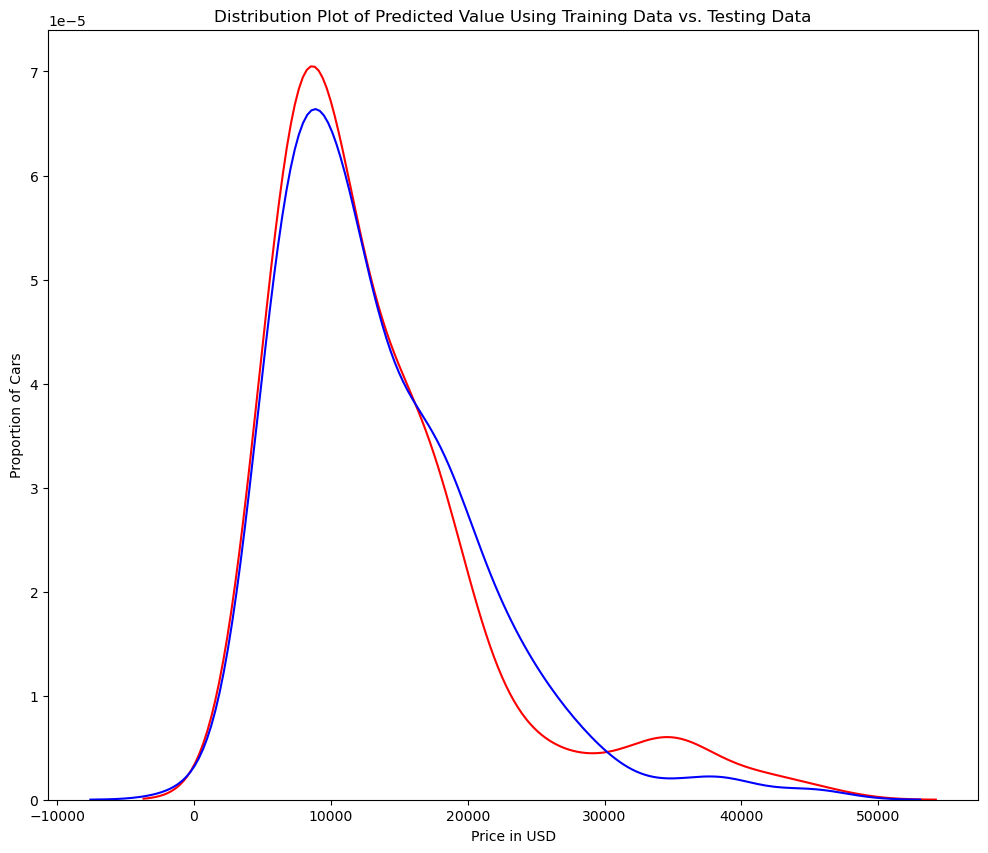

In [62]:
# evaluating models by plotting
title = 'Distribution Plot of Predicted Value Using Training Data vs. Testing Data'
DistributionPlot(y_train, yhat_train, 'Actual Values (Train)', 'Predicted Values (Train)', title)

From this distribution plot, we can see that the models seems to be doing fairly well in learning from the training dataset, but what happens if the model encounters new data?

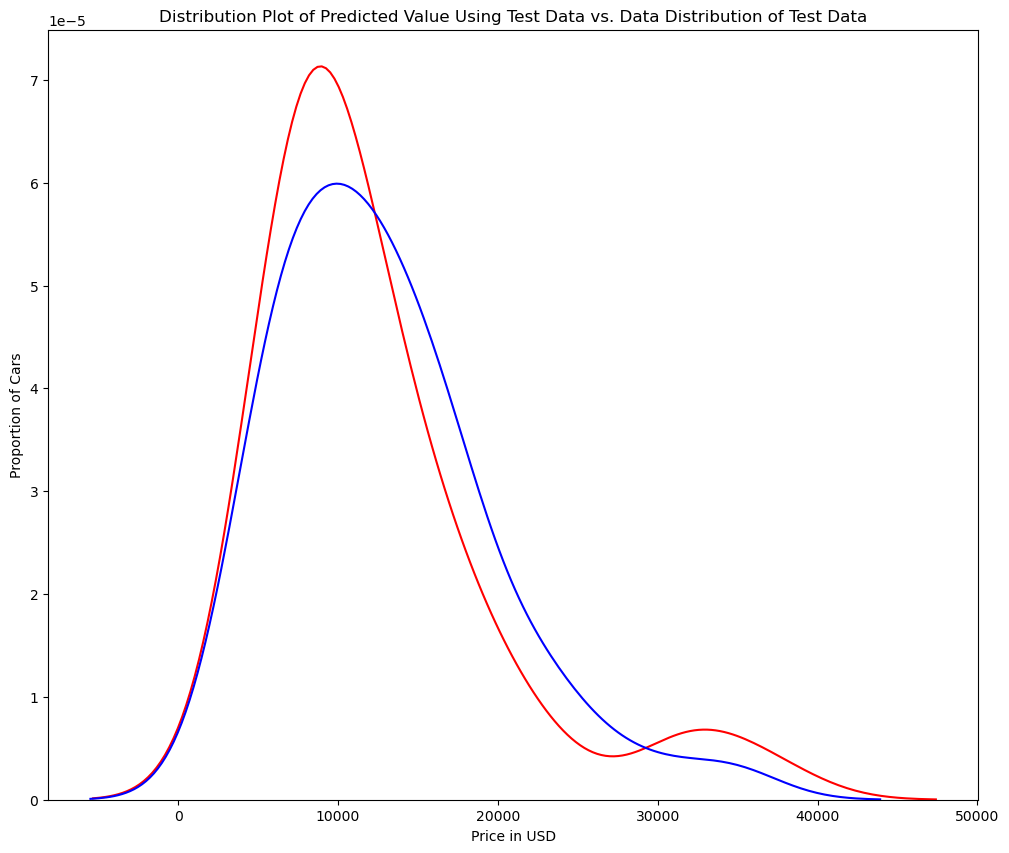

In [63]:
# checking the distribution plot when the model generates new values from the test data
title = 'Distribution Plot of Predicted Value Using Test Data vs. Data Distribution of Test Data'
DistributionPlot(y_test, yhat_test, 'Actual Values (Test)', 'Predicted Values (Test)', title)

By comparing the two distributions we can see Figure 1 is better at fitting the data. Let's see if polynomial regression also shows a drop in prediction accuracy.
### Overfitting
* models fits the noise, but not the underlying relationship

In [64]:
# creating a fifth degree polynomial with 55% of the data for training
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.45, random_state=0)

In [65]:
# fifth degree polynomial on 'horsepower'
pr = PolynomialFeatures(degree=5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])
pr

PolynomialFeatures(degree=5)

In [66]:
poly = LinearRegression()
poly.fit(x_train_pr, y_train)

LinearRegression()

In [67]:
yhat = poly.predict(x_test_pr)
yhat[0:5]

array([ 6727.58220328,  7306.70943599, 12213.70784162, 18895.0330728 ,
       19996.83492492])

In [68]:
print('Predicted values:', yhat[0:4])
print('True values:', y_test[0:4])

Predicted values: [ 6727.58220328  7306.70943599 12213.70784162 18895.0330728 ]
True values: 18      6295.0
170    10698.0
107    13860.0
98     13499.0
Name: price, dtype: float64


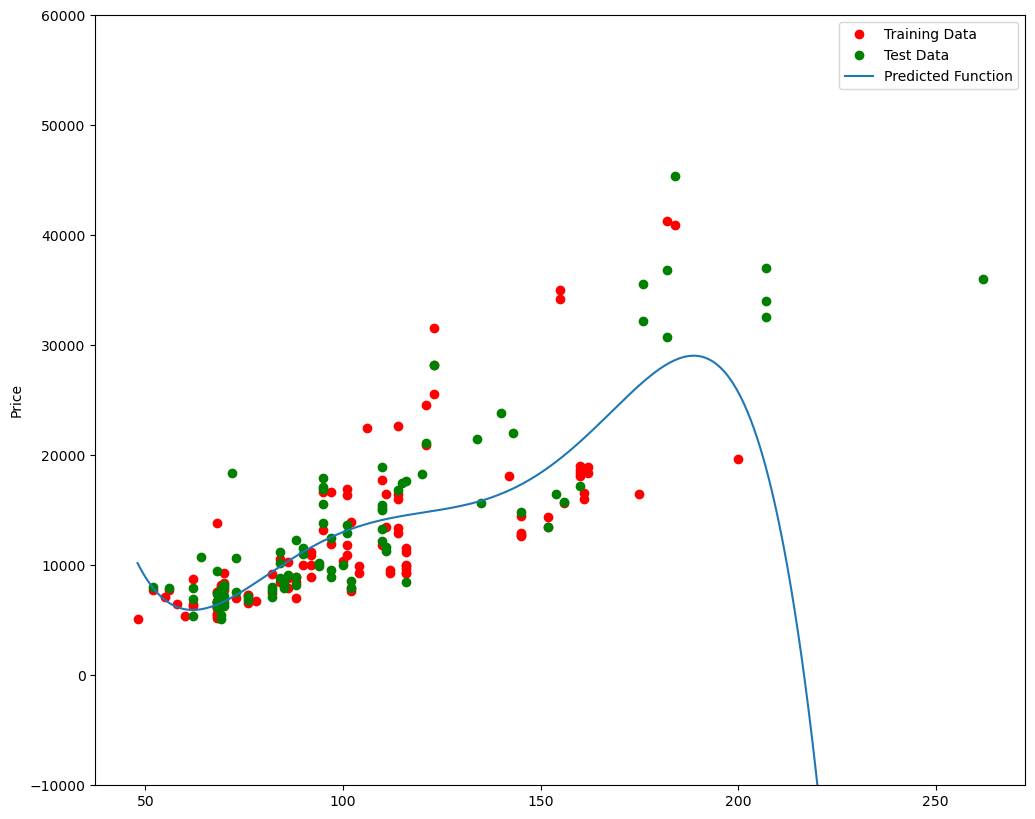

In [69]:
PolyPlot(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly, pr)

From the polynomial regression model we can see the estimated function appears to track the data until around 200 horsepower when the function begins to diverge from the data points.

Now we'll look at the r-squared values:

In [70]:
# r-squared of the training data
poly.score(x_train_pr, y_train)

0.5568527853920433

In [71]:
# r-squared of the test data
poly.score(x_test_pr, y_test)

-29.815556313159167

We can see the r<sup>2</sup> of the training data is 0.5567 while the r<sup>2</sup> of the test data is -29.87. A lower r<sup>2</sup> reflects a worse model where a negative r<sup>2</sup> is a sign of overfitting.

Now let's check how the r<sup>2</sup> changes on the test data for different orders.

Text(3, 0.75, 'Maximum R^2')

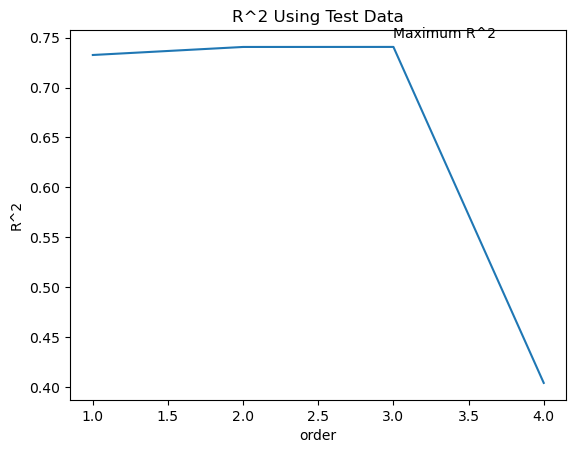

In [72]:
Rsqu_test = []

order = [1, 2, 3, 4]

for n in order:
    pr = PolynomialFeatures(degree=n)
    
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    
    lr.fit(x_train_pr, y_train)
    
    Rsqu_test.append(lr.score(x_test_pr, y_test))

plt.plot(order, Rsqu_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2')

We see the r<sup>2</sup> gradually increase until an order three polynomial is used then the r<sup>2</sup> dramatically decreases.

## Ridge Regression

In [73]:
pr = PolynomialFeatures(degree=2)
x_train_pr = pr.fit_transform(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg', 'normalized-losses', 'symboling']])
x_test_pr = pr.fit_transform(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg', 'normalized-losses', 'symboling']])

In [74]:
# creating a ridge regression object
rmodel = Ridge(alpha=1)

In [75]:
# fitting the model
rmodel.fit(x_train_pr, y_train)

Ridge(alpha=1)

In [76]:
yhat = rmodel.predict(x_test_pr)

In [77]:
print('predicted:', yhat[0:4])
print('test set:', y_test[0:4].values)

predicted: [ 6572.19586866  9634.40697746 20948.17104272 19403.38016094]
test set: [ 6295. 10698. 13860. 13499.]


We'll make a for loop to select the alpha that minimizes the test error.

In [78]:
from tqdm import tqdm

rsqr_test = []
rsqr_train = []
dummy1 = []
alpha = 10 * np.array(range(0,1000))
pbar = tqdm(alpha)

for p in pbar:
    rmodel = Ridge(alpha=p)
    rmodel.fit(x_train_pr, y_train)
    test_score, train_score = rmodel.score(x_test_pr, y_test), rmodel.score(x_train_pr, y_train)
    
    pbar.set_postfix({'Test Score': test_score, 'Train Score': train_score})
    
    rsqr_test.append(test_score)
    rsqr_train.append(train_score)

100%|██████████| 1000/1000 [00:03<00:00, 270.20it/s, Test Score=0.564, Train Score=0.859]


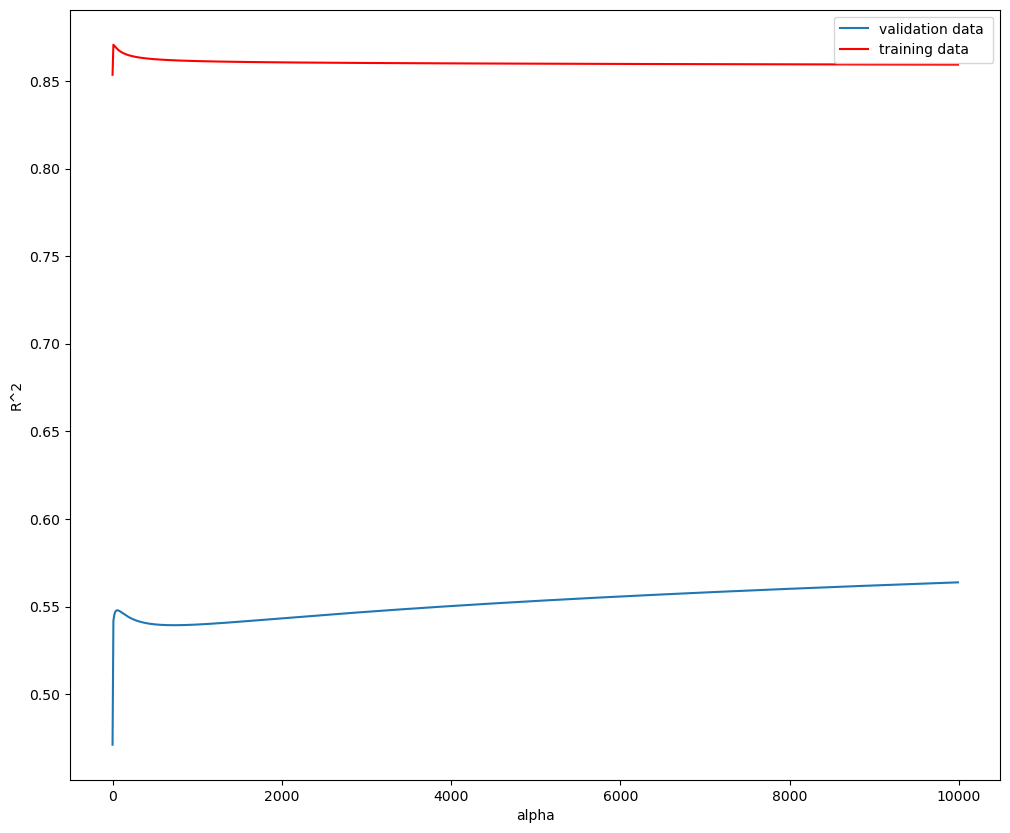

In [79]:
plt.figure(figsize=(12,10))

plt.plot(alpha, rsqr_test, label='validation data ')
plt.plot(alpha, rsqr_train, 'r', label='training data ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

Above we can see that the red line  represents the r<sup>2</sup> of the training data which decreases as alpha increases. For the training data, as alpha increases, the model performs worse. The blue line represents the r<sup>2</sup> on the validation data. For the validation data, as alpha increase, r<sup>2</sup> increases and converges at a point.

## Grid Search
* using GridSearchCV to find the best hyperparameter

First we'll create a dictionary of parameter values:

In [86]:
# creating a dictionary of parameter values
parameters1 = [{'alpha': [0.001, 0.1, 1, 10, 100, 10000, 100000]}]
parameters1

[{'alpha': [0.001, 0.1, 1, 10, 100, 10000, 100000]}]

In [87]:
# creating a ridge regression object
RR = Ridge()
RR

Ridge()

In [88]:
# creating a ridge grid search object
Grid1 = GridSearchCV(RR, parameters1, cv=4)

In [89]:
# fitting the model
Grid1.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)

GridSearchCV(cv=4, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.1, 1, 10, 100, 10000, 100000]}])

In [90]:
# using .best_estimator_ to obtain the estimator with the best parameters and assigning it to a variable
BestRR = Grid1.best_estimator_
BestRR

Ridge(alpha=10000)

Now we'll test our model.

In [92]:
# testing the model on the test data
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411781387793232

Best ridge regression score: 0.8411781387793232

(end)